# Otoliths predictions

In [1]:
%matplotlib inline 
from util.useful_imports import *

## Exploratory analysis

** Load images from the root folder... **

In [2]:
loader = ImageFolder(root=TRAIN_DIR)
label_map = dict({loader.class_to_idx[name]: name for name in loader.classes})

There are 503 images with 6 different labels:

Dikkop (33)
Haring (78)
Kleine zandspiering (214)
Smelt (45)
Sprot (97)
Wijting (36)


[Text(0,0,'Dikkop'),
 Text(0,0,'Haring'),
 Text(0,0,'Kleine zandspiering'),
 Text(0,0,'Smelt'),
 Text(0,0,'Sprot'),
 Text(0,0,'Wijting')]

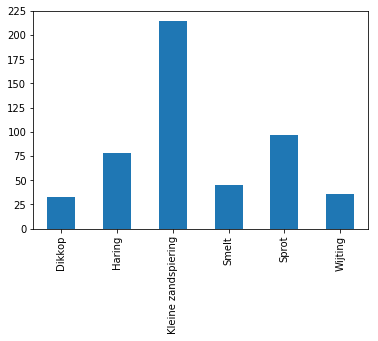

In [3]:
# print statitics
print('There are {} images with {} different labels:\n'.format(len(loader), len(loader.classes)))
frequencies = []
for label in loader.classes:
    idx = loader.class_to_idx[label]
    cant = sum([1 for (_, it) in loader if it == idx])
    frequencies.append(cant)
    print('{} ({})'.format(label, cant))   

freq_series = pd.Series.from_array(frequencies)
ax = freq_series.plot(kind='bar')
ax.set_xticklabels(loader.classes)    

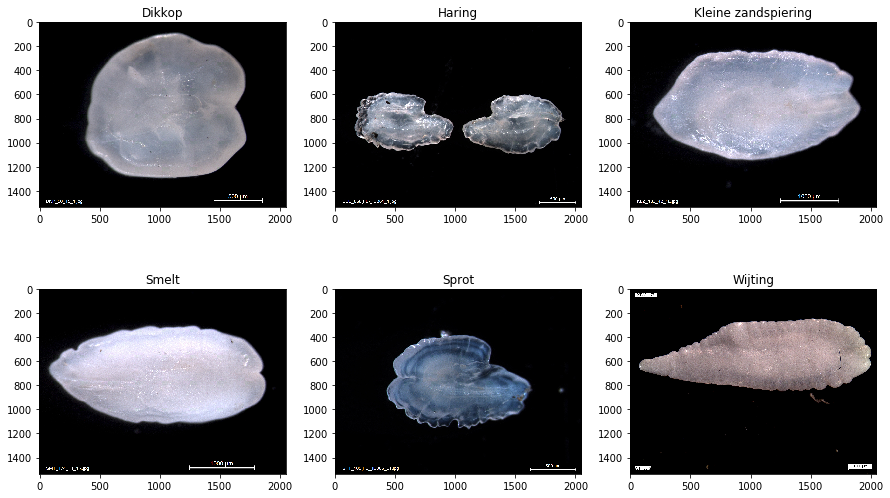

In [5]:
nrows, ncols = 2, 3
f, axs = plt.subplots(nrows, ncols, figsize=(15,9))

next_id = 0
for i in range(nrows):
    for j in range(ncols):
        idx = random.randint(0,len(loader)-1)
        while (loader[idx][1] != next_id):
            idx = random.randint(1,len(loader))
        axs[i,j].imshow(loader[idx][0])
        axs[i,j].set_title(label_map[loader[idx][1]])
        next_id = next_id + 1

# Images
**Look closer to an individual image...**

One image has size of 2048x1536


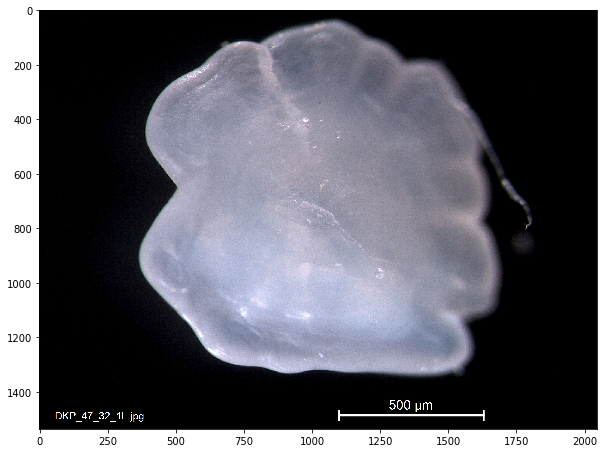

In [6]:
width, height = loader[1][0].size
print("One image has size of {}x{}".format(width, height))
plt.figure(figsize=(10,10))
plt.imshow(loader[0][0])

# Data processing

### Removing meta-info
** Data augmentation **
* Crop image
* Resize to 224 x 224
* Random Horizontal Flip
* Random Rotation (-45,+45)

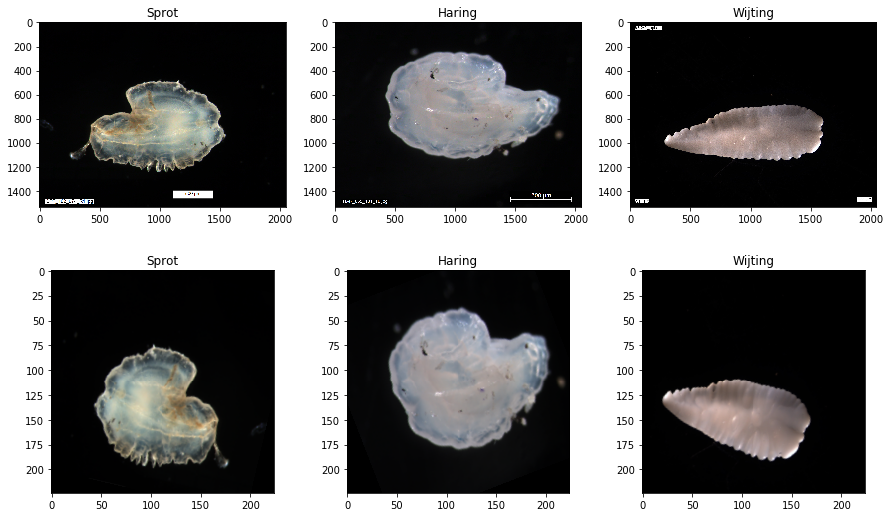

In [6]:
nrows, ncols = 2, 3
f, axs = plt.subplots(nrows, ncols, figsize=(15,9))

for j in range(ncols):
    idx = random.randint(0,len(loader)-1)
    axs[0,j].imshow(loader[idx][0])
    axs[0,j].set_title(label_map[loader[idx][1]])
    axs[1,j].imshow(data[idx][0])
    axs[1,j].set_title(label_map[data[idx][1]])  

# Test performance

** Residual Networks for Image Recognition (reset18)**

<img src="data/block.png" style="max-width:50%; width: 50%">
<img src="data/resnet18.png" style="max-width:50%; width: 50%">

** Train model **
* Loss function
$$\text{Softmax}(x_{i}) = \frac{\exp(x_i)}{\sum_j \exp(x_j)}$$
* Stochastic Gradient Descent with Momentum 0.9, weight decay 0.0001
* 50 epochs
* batch size 16
* valid error = 0.88

** Load model **

In [7]:
checkpoint = torch.load('output/best_resnet18.pth.tar', map_location=lambda storage, loc: storage)
model = models.resnet18()
model = CNNs.FineTuneModel(model, 'resnet18', len(loader.classes))
model.load_state_dict(checkpoint['state_dict'])

def predict_label(output):
    """ Compute the accuracy """
    _, pred = torch.max(output, 1)
    return label_map[pred.cpu().numpy().tolist()[0]]

** Predict **

** Correct predictions**

  9%|▉         | 5/53 [00:02<00:23,  2.03it/s]


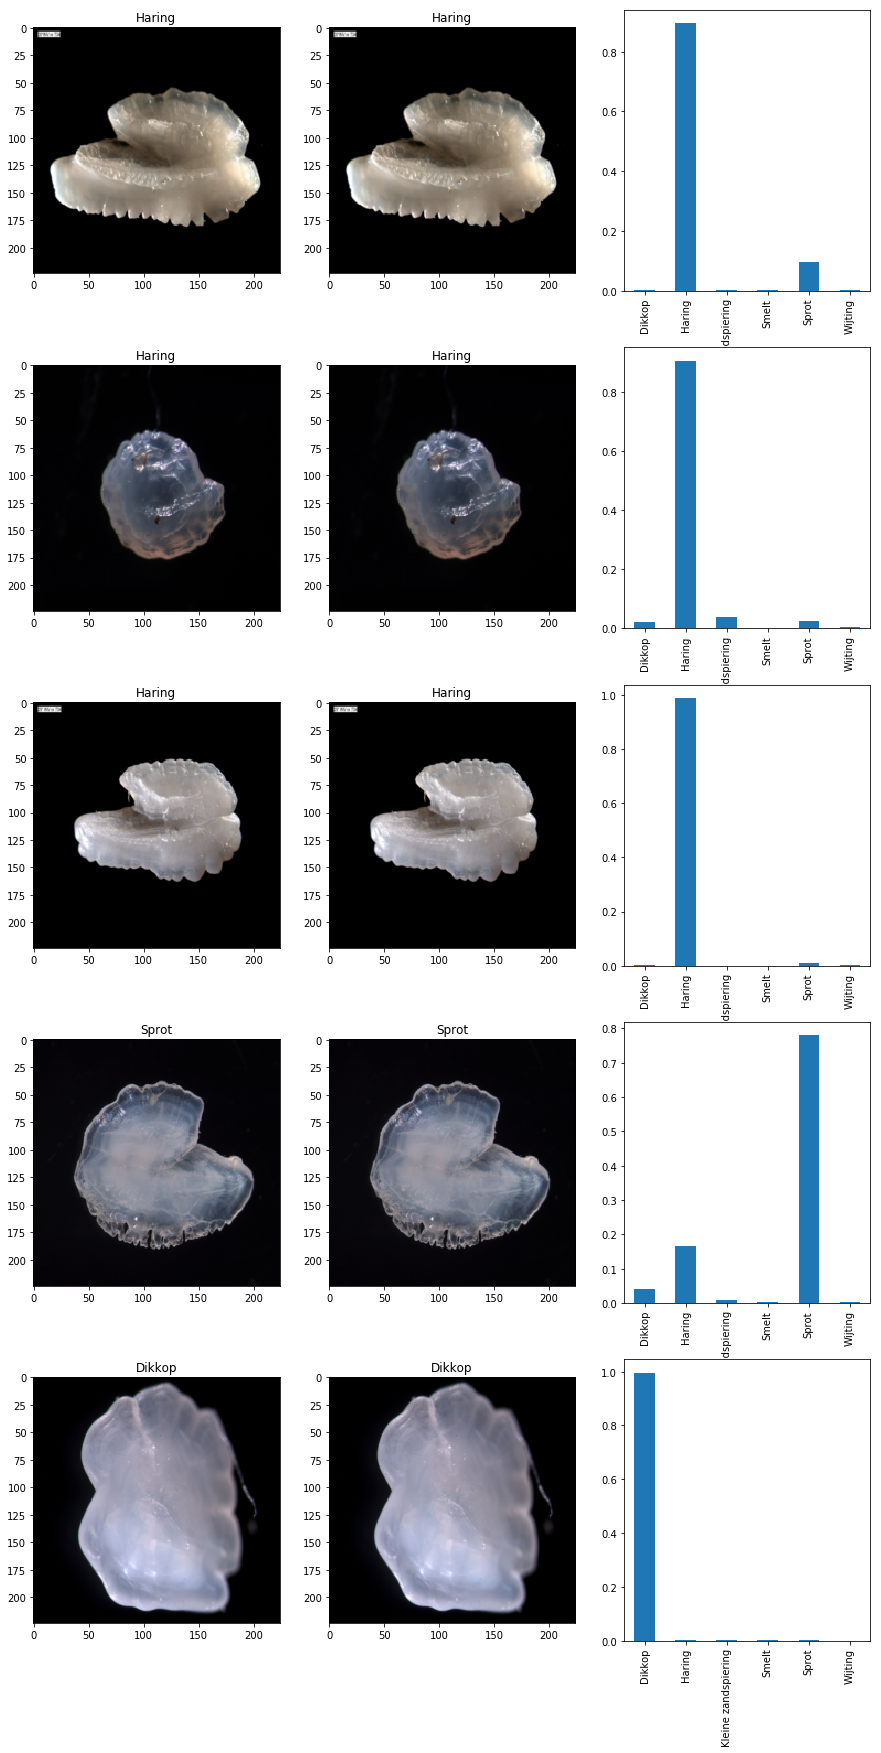

In [11]:
nrows, ncols = 5, 3
f, axs = plt.subplots(nrows, ncols, figsize=(15,30))

model.eval()
cnt = 0
sigmoid = nn.Softmax()
names = [label_map[i] for i in label_map.keys()]

for i in tqdm(range(len(dset_valid))):
    idx = random.randint(0,len(dset_valid)-1)
    img = dset_valid[idx][0]
    img = Variable(img[None, :])
    
    output = model(img)
    pred =  predict_label(output.data)       
    
    if (label_map[dset_valid[idx][1]] != pred):
        continue
    
    axs[cnt,0].imshow(dsetreal[idx][0])
    axs[cnt,0].set_title(label_map[dset_valid[idx][1]])
    
    axs[cnt,1].imshow(dsetreal[idx][0])
    axs[cnt,1].set_title(pred)
    
    #.
    pro = sigmoid(output).data.cpu().numpy()
    freq_series = pd.Series.from_array(pro[0,:])
    axs[cnt,2] = freq_series.plot(kind='bar', ax=axs[cnt,2])
    axs[cnt,2].set_xticklabels(names)
    
    
    cnt = cnt + 1
    if (cnt == nrows):
        break
    

** Incorrect predictions **

 98%|█████████▊| 52/53 [00:15<00:00,  3.63it/s]

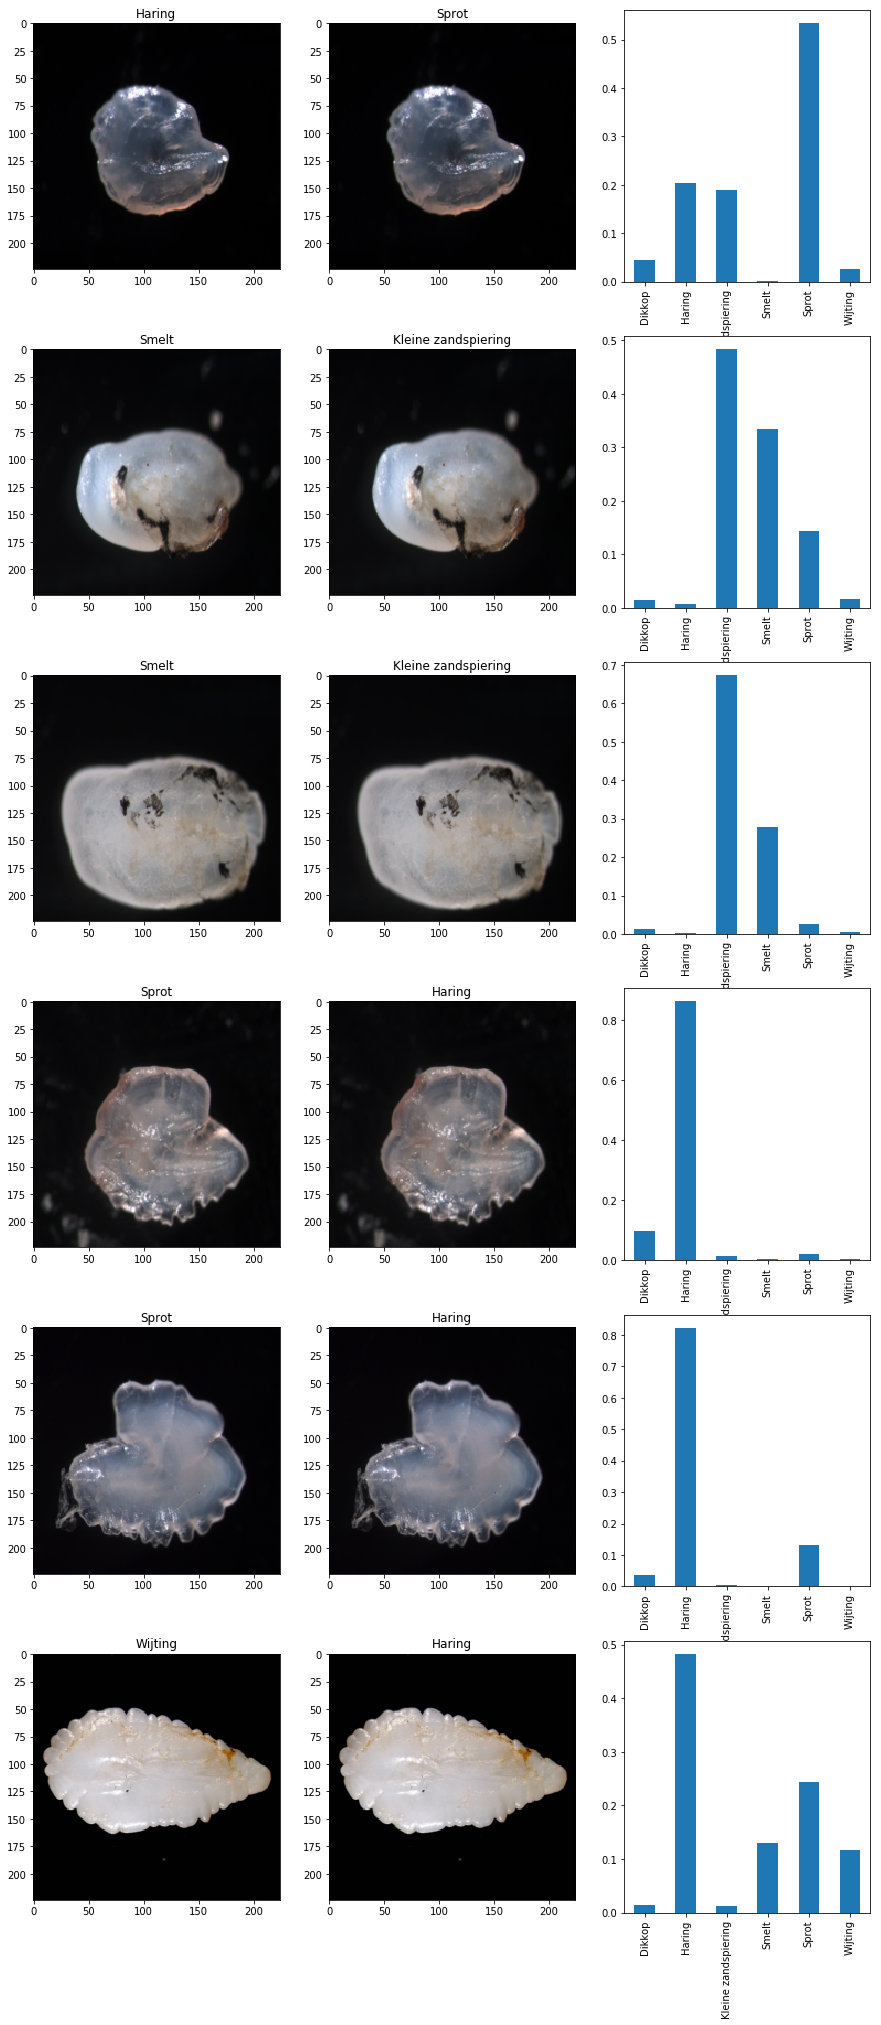

In [8]:
nrows, ncols = 6, 3
f, axs = plt.subplots(nrows, ncols, figsize=(15,35))

model.eval()
cnt = 0
sigmoid = nn.Softmax()
names = [label_map[i] for i in label_map.keys()]

for i in tqdm(range(len(dset_valid))):
    idx = i #random.randint(0,len(dset_valid)-1)
    img = dset_valid[idx][0]
    img = Variable(img[None, :])
    
    output = model(img)
    pred =  predict_label(output.data)       
    
    if (label_map[dset_valid[idx][1]] == pred):
        continue
    
    axs[cnt,0].imshow(dsetreal[idx][0])
    axs[cnt,0].set_title(label_map[dset_valid[idx][1]])
    
    axs[cnt,1].imshow(dsetreal[idx][0])
    axs[cnt,1].set_title(pred)
    
    #.
    pro = sigmoid(output).data.cpu().numpy()
    freq_series = pd.Series.from_array(pro[0,:])
    axs[cnt,2] = freq_series.plot(kind='bar', ax=axs[cnt,2])
    axs[cnt,2].set_xticklabels(names)
    
    
    cnt = cnt + 1
    if (cnt == nrows):
        break
    

# Problems
* **Mismatched training and test distributions ** (training images are high-resolution images)